In [1]:
import h5py
import glob
import os
import sys
import sympy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, accuracy_score, r2_score
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.initializers import Zeros, RandomNormal
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from sklearn.metrics import roc_curve, auc
import tensorflow.keras.backend as K
import qkeras
from qkeras import *

np.random.seed(42)
tf.random.set_seed(42)

## read data

In [2]:
data_files = sorted(glob.glob('recon3D/recon3D_d*.parquet'))
labels_files = sorted(glob.glob('labels/labels_d*.parquet'))

chunk_size = 10
data_chunks = []
labels_chunks = []
n_files = 0

#for i in range(0, len(data_files), chunk_size):
for i in range(0, 100, chunk_size):
    data_chunk_files = data_files[i:i+chunk_size]
    labels_chunk_files = labels_files[i:i+chunk_size]
    
    data_chunk_list = []
    labels_chunk_list = []
    
    for rf, lf in zip(data_chunk_files, labels_chunk_files):
        d = pd.read_parquet(rf)
        l = pd.read_parquet(lf)
        
        data_chunk_list.append(d)
        labels_chunk_list.append(l[['y-local', 'pt']])
        
        n_files += 1
        print(f"Processed {n_files} files", end='\r')
        sys.stdout.flush()
    
    chunk_data_df = pd.concat(data_chunk_list, ignore_index=True)
    chunk_labels_df = pd.concat(labels_chunk_list, ignore_index=True)
    
    data_chunks.append(np.reshape(chunk_data_df.to_numpy(), (-1, 20, 13, 21)))
    labels_chunks.append(chunk_labels_df)

del data_chunk_list, labels_chunk_list, d, l, chunk_data_df, chunk_labels_df

## plot data

In [3]:
n = 5
data = np.concatenate(data_chunks[:n], axis=0)
labels = pd.concat(labels_chunks[:n], ignore_index=True)

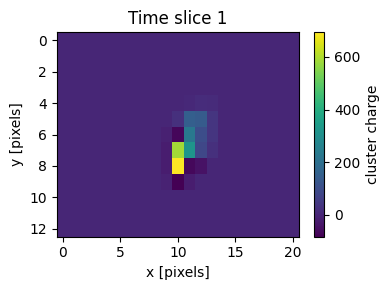

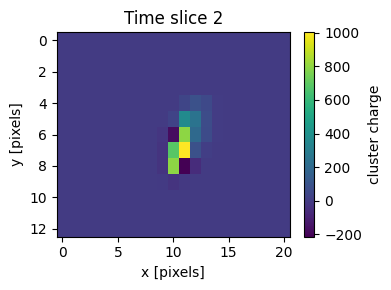

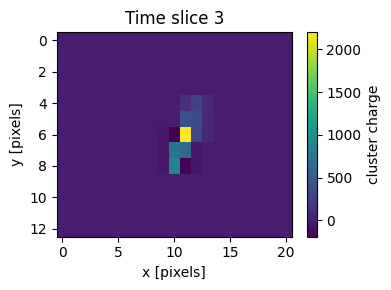

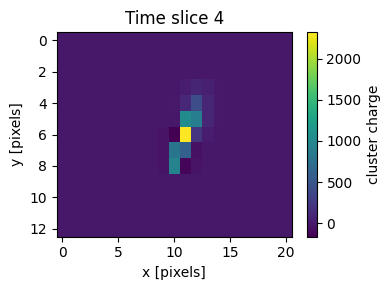

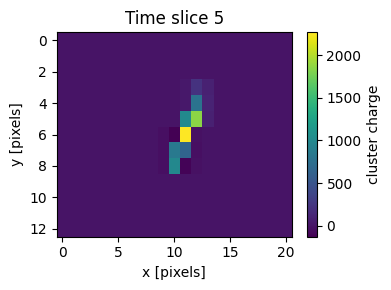

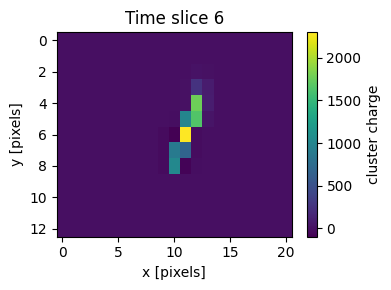

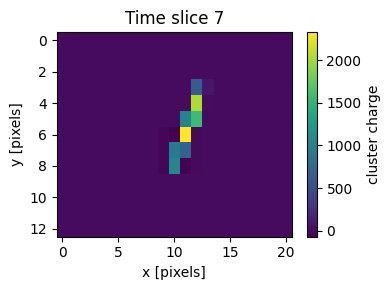

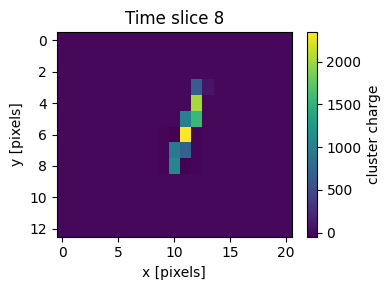

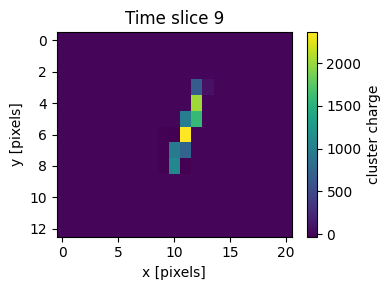

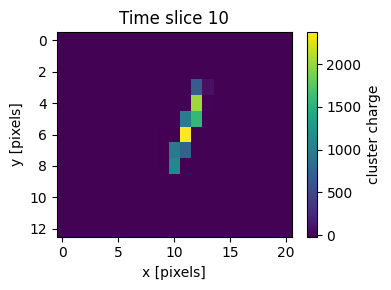

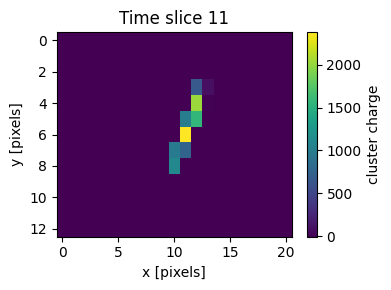

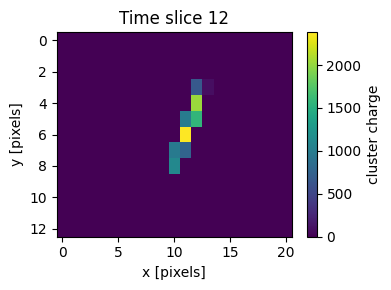

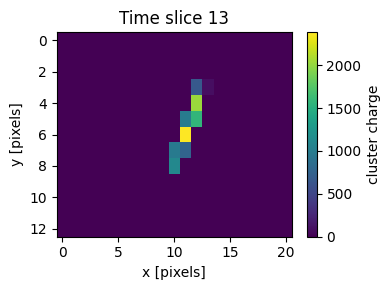

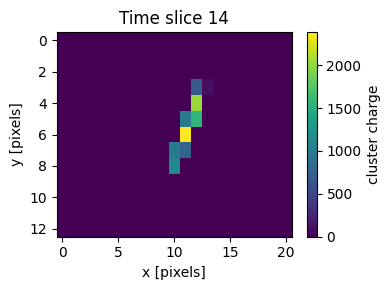

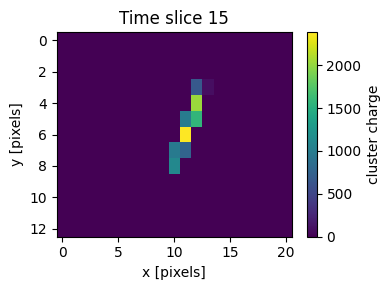

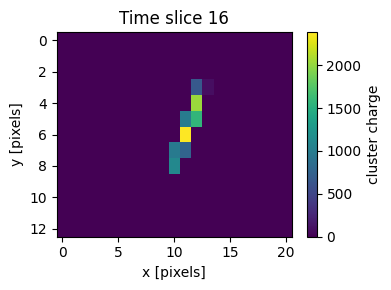

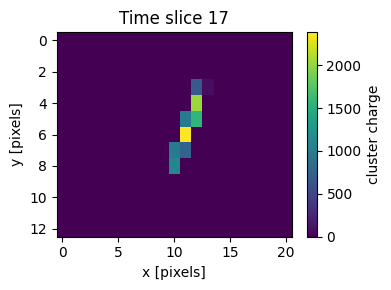

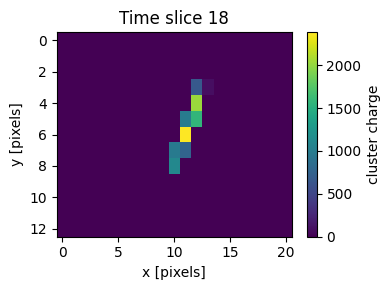

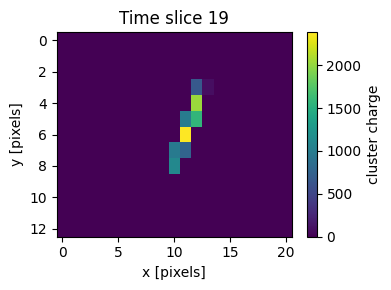

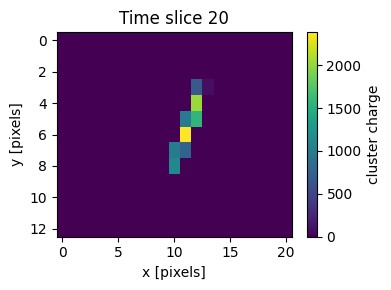

In [4]:
for i in range(data[0].shape[0]):
    plt.figure(figsize=(4, 3))
    plt.imshow(data[0][i], aspect='auto', cmap='viridis')
    plt.title(f'Time slice {i+1}')
    plt.xlabel('x [pixels]')
    plt.ylabel('y [pixels]')
    plt.colorbar(label='cluster charge')
    plt.tight_layout()
    plt.show()

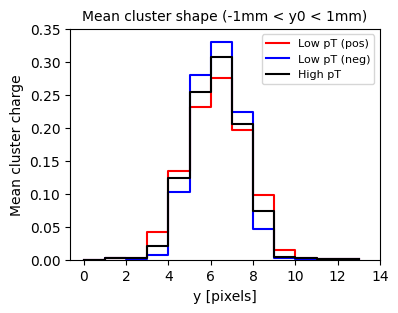

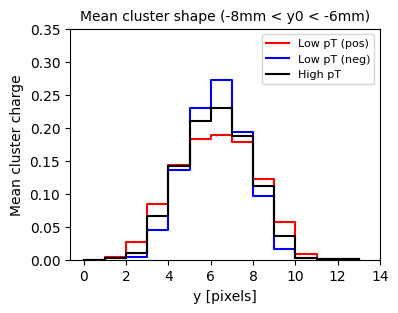

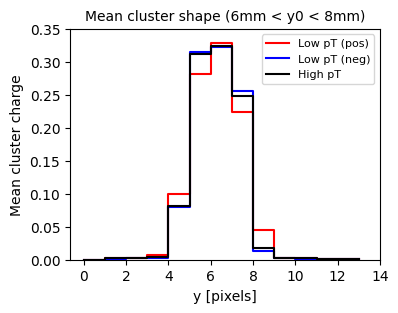

In [5]:
y0_range = [(-1, 1), (-8, -6), (6, 8)]
for r in y0_range:
    data_y0range = data[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    labels_y0range = labels[(labels['y-local'] > r[0]) & (labels['y-local'] < r[1])]
    
    # take the last time slice, and sum over x to get y profile
    y_profile = data_y0range[:, -1, :, :].sum(axis = -1)
    
    y_profile_low_pos = y_profile[(labels_y0range['pt'] < 0.2) & (labels_y0range['pt'] > 0)]
    y_profile_low_neg = y_profile[(labels_y0range['pt'] > -0.2) & (labels_y0range['pt'] < 0)]
    y_profile_high = y_profile[(labels_y0range['pt'] > 0.2) | (labels_y0range['pt'] < -0.2)]
    
    y_profile_low_pos_mean = y_profile_low_pos.mean(axis = 0)
    y_profile_low_neg_mean = y_profile_low_neg.mean(axis = 0)
    y_profile_high_mean = y_profile_high.mean(axis = 0)
    
    edges = np.arange(len(y_profile_low_pos_mean) + 1)
    
    y_profile_low_pos_mean = np.concatenate(([0], y_profile_low_pos_mean))
    y_profile_low_neg_mean = np.concatenate(([0], y_profile_low_neg_mean))
    y_profile_high_mean = np.concatenate(([0], y_profile_high_mean))
    
    plt.figure(figsize=(4, 3))
    plt.step(edges, y_profile_low_pos_mean/np.sum(y_profile_low_pos_mean), where='post', label = 'Low pT (pos)', color='red')
    plt.step(edges, y_profile_low_neg_mean/np.sum(y_profile_low_neg_mean), where='post', label = 'Low pT (neg)', color='blue')
    plt.step(edges, y_profile_high_mean/np.sum(y_profile_high_mean), where='post', label = 'High pT', color='black')
    plt.title(f"Mean cluster shape ({r[0]}mm < y0 < {r[1]}mm)", size=10)
    #plt.ylim(0, max(y_profile_low_neg_mean)*1.25)
    plt.ylim(0, 0.35)
    plt.xlabel("y [pixels]")
    plt.ylabel("Mean cluster charge")
    plt.xticks(np.arange(0, len(y_profile_low_pos_mean) + 1, 2))
    plt.legend(fontsize=8)
    plt.show()

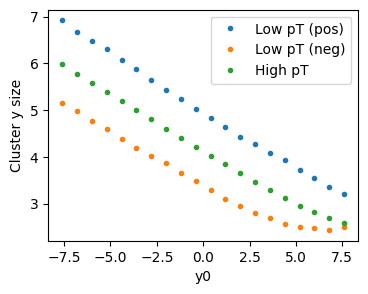

In [6]:
y_profile = data[:, -1, :, :].sum(axis = -1)
y_size = np.count_nonzero(y_profile, axis=1, keepdims=True)
y_size = y_size.flatten() 
labels = labels.copy()
labels['y_size'] = y_size

bins = np.linspace(-8, 8, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2

group1 = labels[(labels['pt'] > 0) & (labels['pt'] < 0.2)]
group2 = labels[(labels['pt'] > -0.2) & (labels['pt'] < 0)]
group3 = labels[(labels['pt'] > 0.2) | (labels['pt'] < -0.2)]

def compute_bin_means(df, bins):
    bin_means = []
    for i in range(len(bins) - 1):
        lower, upper = bins[i], bins[i + 1]

        if i == len(bins) - 2:
            mask = (df['y-local'] >= lower) & (df['y-local'] <= upper)
        else:
            mask = (df['y-local'] >= lower) & (df['y-local'] < upper)

        bin_mean = df.loc[mask, 'y_size'].mean()
        bin_means.append(bin_mean)

    return np.array(bin_means)

bin_means1 = compute_bin_means(group1, bins)
bin_means2 = compute_bin_means(group2, bins)
bin_means3 = compute_bin_means(group3, bins)

plt.figure(figsize=(4, 3))
plt.plot(bin_centers, bin_means1, marker='.', linestyle='none', label="Low pT (pos)")
plt.plot(bin_centers, bin_means2, marker='.', linestyle='none', label="Low pT (neg)")
plt.plot(bin_centers, bin_means3, marker='.', linestyle='none', label="High pT")
plt.xlabel('y0')
plt.ylabel('Cluster y size')
plt.legend()
#plt.grid(True)
plt.show()

In [ ]:
del data, labels

## prepare data

In [ ]:
for i in range(len(data_chunks)):
    data_chunks[i] = data_chunks[i][:, -1, :, :].sum(axis = -1)

n = 16
data = np.concatenate(data_chunks[:n], axis=0)
del data_chunks
labels = pd.concat(labels_chunks[:n], ignore_index=True)
del labels_chunks

In [ ]:
X = np.hstack((labels['y-local'].to_numpy().reshape(-1, 1), np.count_nonzero(data, axis=1, keepdims=True), data))
del data

pt_truth = labels['pt'].to_numpy()
del labels

Y = np.zeros((pt_truth.size, 3))
Y[:, 2] = 1
Y[np.where((pt_truth >= 0) & (pt_truth < 0.2))] = [1, 0, 0]
Y[np.where((pt_truth < 0) & (pt_truth > -0.2))] = [0, 1, 0]

print(X.shape)
print(Y.shape)
print(np.sum(Y, axis=0))
print(pt_truth.shape)

In [ ]:
class0_idx = np.where(Y[:, 0] == 1)[0]
class1_idx = np.where(Y[:, 1] == 1)[0]
class2_idx = np.where(Y[:, 2] == 1)[0]

min_count = min(len(class0_idx), len(class1_idx), len(class2_idx))

chosen_class0 = np.random.choice(class0_idx, min_count, replace=False)
chosen_class1 = np.random.choice(class1_idx, min_count, replace=False)
chosen_class2 = np.random.choice(class2_idx, min_count, replace=False)

balanced_idx = np.concatenate([chosen_class0, chosen_class1, chosen_class2])

np.random.shuffle(balanced_idx)

X_balanced = X[balanced_idx]
Y_balanced = Y[balanced_idx]
pt_truth_balanced = pt_truth[balanced_idx]

all_indices = np.arange(Y.shape[0])
rest_idx = np.setdiff1d(all_indices, balanced_idx)

X_rest = X[rest_idx]
Y_rest = Y[rest_idx]
pt_truth_rest = pt_truth[rest_idx]

del X, Y, pt_truth

print(X_balanced.shape)
print(Y_balanced.shape)
print(np.sum(Y_balanced, axis=0))
print(pt_truth_balanced.shape)

print(X_rest.shape)
print(Y_rest.shape)
print(np.sum(Y_rest, axis=0))
print(pt_truth_rest.shape)

In [ ]:
train_ratio = 0.6
val_ratio = 0.05
test_ratio = 1 - train_ratio - val_ratio
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_balanced, Y_balanced, test_size = test_ratio, random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio + train_ratio), random_state = 42)

pt_truth_train_val, pt_truth_test = train_test_split(pt_truth_balanced, test_size = test_ratio, random_state = 42)

X_test = np.concatenate((X_test, X_rest), axis=0)
Y_test = np.concatenate((Y_test, Y_rest), axis=0)
pt_truth_test = np.concatenate((pt_truth_test, pt_truth_rest), axis=0)

print('X_train shape: ' + str(X_train.shape))
print('X_val   shape: ' + str(X_val.shape))
print('X_test  shape: ' + str(X_test.shape))
print('Y_train shape: ' + str(Y_train.shape))
print('Y_val   shape: ' + str(Y_val.shape))
print('Y_test  shape: ' + str(Y_test.shape))
print('pt_truth_test  shape: ' + str(pt_truth_test.shape))

del X_balanced, Y_balanced, pt_truth_balanced, X_rest, Y_rest, pt_truth_rest, X_train_val, Y_train_val, pt_truth_train_val

In [ ]:
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('Y_train.npy', Y_train)
np.save('Y_val.npy', Y_val)
np.save('Y_test.npy', Y_test)
np.save('pt_truth_test.npy', pt_truth_test)